### Dynamic Routing Between Capsules

#### Capsule

- A capsule is a group of neurons whose activity vectors represent various instantiation parameters of an object.
- The whole process
    - Active capsules at the lower level(triangle, rectangle) makes prediction for the instantiation parameters of higher level capsules(boat, house).
    - When multiple capsules of a lower level come to an agreement, the capsules at higher level become active.
    - The probability of presence of entity is determined by the length of the activity vectors and the vector's orientation tells about the properties of an entity.

In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torchvision import datasets, transforms

device = torch.device("cuda:0")

In [2]:
class Mnist:
    def __init__(self, batch_size):
        dataset_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

        train_dataset = datasets.MNIST('./mnist', train=True, download=True, transform=dataset_transform)
        test_dataset = datasets.MNIST('./mnist', train=False, download=True, transform=dataset_transform)
        
        self.train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#### Primary Capsule layer
- In this layer, we replace the scaler-output feature detector of CNN with 8-dim vector output capsule.
- The primary capsules are the lowest level of entities.
- Equivarience: translation of input features results in an equivalent translation of outputs. 
    - Traditional CNN fails to encode these feature due to the nature of scalar-output feature detector and pooling layers.
- This layer can be designed using several Convolution layer. In the paper, authors used a stack of 8 Convolution layer each with 32 feature maps, kernel size of 9x9, stride 2 and zero padding. We pass the output of the first convolution through every convolution in this layer and our expected final output is [batch_size,primary_num_capsule,primary_capsule_dim]. So we need to reshape the initial output shape to get our expected shape.

- **squash function**
    - They use non-linear activation, squashing function, so that the length of output vector becomes less than 1 because it is used to represent probability.
$$v_{j} = \dfrac{||s_j||^2}{1 + ||s_j||^2} \dfrac{s_j}{||s_j||}$$

In [3]:
class PrimaryCaps(nn.Module):
    def __init__(self, num_capsules=8, in_channels=256, out_channels=32, kernel_size=9):
        super(PrimaryCaps, self).__init__()

        self.capsules = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=2, padding=0) 
                          for _ in range(num_capsules)])
            
    def forward(self, x):      
        u = [capsule(x).view(x.size(0), -1, 1) for capsule in self.capsules]   
        u = torch.cat(u, dim=-1)
        
        return self.squash(u)  # [128, 1152, 8]
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)  # 8-dim vector의 norm이 1보다 작아지게 squashing
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

#### Routing By agreement
- When the capsules at the lowel level come upon an agreement over the presence of an entity at higher level, only the capsule corresponding to that entity becomes active. Hence, other capsules are rejected and this is instrumental in **removing noise** from the model. 
- Therefore, when there is a strong agreement between the capsules at the lower levels for the activity of the capsules at the higher level, the capsules at the lower level are **routed** to the capsules at higher level.
- In MNIST case, 
    - Every capsule in the Primary layer tries to predict the output of every capsule in Digit layer.
    - 자신의 prediction과 일치하는(scalar product가 큰) higher level capsule에게 자신의 output을 전달.
    - Using the output vector of primary capsule we will predict the output vector of digit capsule by fully-connected layer.
    - we need a matrix, $W_{ij}$ for each pair of capsule in primary and digit layer. primary capsule 8D, digit capsule 16D, so $W_{ij}$ is $8 \times 16$
    - **prediction vector**: $\hat{u}_{j|i} = W_{ij}u_{i}$
    - 각 1152개 prime caps가 10개 digit caps에 대해 모두 개별 예측을 한 것. 
    - Compute the weighted sum of all the ‘predicted output vectors’ $\hat{u}_{j|i}$ for each digit capsule. $s_j = \sum{c_{ij}\hat{u}_{j|i}}$
    - The output of digit capsule $s_j$ might give vectors larger than 1, so we need to squash these 16 dimensional vector by $v_j = squash(s_j)$.
    - Now we need to determine which primary capsule agrees with which digit capsule. We just simply compute it by the scalar product of each instance between predicted vector by primary capsule. (u_hat, v_j)

In [4]:
class DigitCaps(nn.Module):
    def __init__(self, num_capsules=10, num_routes=32 * 6 * 6, in_channels=8, out_channels=16):
        super(DigitCaps, self).__init__()

        self.in_channels = in_channels
        self.num_routes = num_routes
        self.num_capsules = num_capsules

        self.W = nn.Parameter(torch.randn(1, num_routes, num_capsules, out_channels, in_channels))
        # (1152,10) 간의 모든 pair에 대해 8x16 matrix를 갖고 있어야 한다. 
        
    def forward(self, x):
        batch_size = x.size(0)
        x = torch.stack([x] * self.num_capsules, dim=2).unsqueeze(4)
        # x.shape : [128, 1152, 10, 8, 1]
        W = torch.cat([self.W] * batch_size, dim=0)
        # W.shape : [128, 1152, 10, 16, 8]
        u_hat = torch.matmul(W, x)
        # u_hat.shape: [128, 1152, 10, 16, 1]
        b_ij = Variable(torch.zeros(1, self.num_routes, self.num_capsules, 1))
        # b_ij.shape: [1, 1152, 10, 1]        
        b_ij = b_ij.to(device)

        num_iterations = 3
        for iteration in range(num_iterations):
            c_ij = F.softmax(b_ij)
            c_ij = torch.cat([c_ij] * batch_size, dim=0).unsqueeze(4)

            s_j = (c_ij * u_hat).sum(dim=1, keepdim=True)
            v_j = self.squash(s_j)
            
            if iteration < num_iterations - 1:
                a_ij = torch.matmul(u_hat.transpose(3, 4), torch.cat([v_j] * self.num_routes, dim=1))
                b_ij = b_ij + a_ij.squeeze(4).mean(dim=0, keepdim=True)

        return v_j.squeeze(1)
    
    def squash(self, input_tensor):
        squared_norm = (input_tensor ** 2).sum(-1, keepdim=True)
        output_tensor = squared_norm *  input_tensor / ((1. + squared_norm) * torch.sqrt(squared_norm))
        return output_tensor

#### Decoder
- Decoder part consist of three Fully Connected layers. It took digit capsules output as input and reconstruct the same input image.
- During training, instead of using all the 16 dimensinal digit capsule they only use the capsule corresponds to the target digit and masked out other capsules to reconstruct the input image. These 16 dimensional digit capsules are feed into a decoder consisting of 3 fully connected layers.

In [5]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        
        self.reconstraction_layers = nn.Sequential(
            nn.Linear(16 * 10, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x, data):
        classes = torch.sqrt((x ** 2).sum(2))
        classes = F.softmax(classes)
        
        _, max_length_indices = classes.max(dim=1)
        masked = Variable(torch.sparse.torch.eye(10))
        
        masked = masked.to(device)
        masked = masked.index_select(dim=0, index=max_length_indices.squeeze(1).data)
        
        reconstructions = self.reconstraction_layers((x * masked[:, :, None, None]).view(x.size(0), -1))
        reconstructions = reconstructions.view(-1, 1, 28, 28)
        
        return reconstructions, masked

In [6]:
class CapsNet(nn.Module):
    def __init__(self):
        super(CapsNet, self).__init__()
        self.conv_layer = nn.Conv2d(in_channels=1, out_channels=256, kernel_size=9)
        self.primary_capsules = PrimaryCaps()
        self.digit_capsules = DigitCaps()
        self.decoder = Decoder()
        
        self.mse_loss = nn.MSELoss()
        
    def forward(self, x):
        x = F.relu(self.conv_layer(x))
        output = self.digit_capsules(self.primary_capsules(x))
        reconstructions, masked = self.decoder(output, data)
        return output, reconstructions, masked
    
    def loss(self, data, x, target, reconstructions):
        return self.margin_loss(x, target) + self.reconstruction_loss(data, reconstructions)
    
    def margin_loss(self, x, labels, size_average=True):
        batch_size = x.size(0)

        v_c = torch.sqrt((x**2).sum(dim=2, keepdim=True))

        left = F.relu(0.9 - v_c).view(batch_size, -1)
        right = F.relu(v_c - 0.1).view(batch_size, -1)

        loss = labels * left + 0.5 * (1.0 - labels) * right
        loss = loss.sum(dim=1).mean()

        return loss
    
    def reconstruction_loss(self, data, reconstructions):
        loss = self.mse_loss(reconstructions.view(reconstructions.size(0), -1), data.view(reconstructions.size(0), -1))
        return loss * 0.0005

In [7]:
capsule_net = CapsNet().to(device)
optimizer = Adam(capsule_net.parameters())

In [8]:
batch_size = 128
mnist = Mnist(batch_size)

n_epochs = 2

In [9]:
for epoch in range(n_epochs):
    capsule_net.train()
    train_loss = 0
    for batch_id, (data, target) in enumerate(mnist.train_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        
        if batch_id % 100 == 0:
            print("train accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
    print(train_loss / len(mnist.train_loader))
        
    capsule_net.eval()
    test_loss = 0
    for batch_id, (data, target) in enumerate(mnist.test_loader):

        target = torch.sparse.torch.eye(10).index_select(dim=0, index=target)
        data, target = Variable(data), Variable(target)

        data, target = data.to(device), target.to(device)

        output, reconstructions, masked = capsule_net(data)
        loss = capsule_net.loss(data, output, target, reconstructions)

        test_loss += loss.item()
        
        if batch_id % 100 == 0:
            print("test accuracy:", sum(np.argmax(masked.data.cpu().numpy(), 1) == 
                                   np.argmax(target.data.cpu().numpy(), 1)) / float(batch_size))
    
    print(test_loss / len(mnist.test_loader))

/home/parkchanwoo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/home/parkchanwoo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


train accuracy: 0.0625
train accuracy: 0.9375
train accuracy: 0.984375
train accuracy: 0.9296875
train accuracy: 1.0
0.2779360364542714
test accuracy: 0.9921875
0.06234931467761156
train accuracy: 0.9609375
train accuracy: 0.96875
train accuracy: 0.984375
train accuracy: 0.984375
train accuracy: 1.0
0.0517857832345627
test accuracy: 0.9921875
0.04099987896713369


In [10]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    "Plot the six MNIST images separately."
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        ax.matshow(images[j-1], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

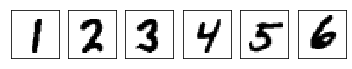

In [11]:
plot_images_separately(data[:6,0].cpu().numpy())

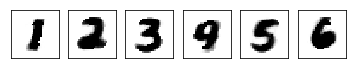

In [12]:
plot_images_separately(reconstructions[:6,0].detach().cpu().numpy())